# Optimising LHL-Syncopation Score

Optimising instrumentation weights in Witek et al. (2014) polyphonic variant on the Longuet-Higgins & Lee (1984) syncopation index.

**Why do we assume the original instrumentation weights are the most appropriate for every experiment?**

Simply uses black-box Bayesian optimisation to derive two- and three-stream syncopation weights that minimise Akaike information criterion (AIC) for a simple OLS linear regression model.

In [1]:
import collections
import itertools
import numpy as np
import optuna
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.api as sm

## Stimulus

In [31]:
# Lucerne Groove Research Library
d_df = pd.read_csv('data.csv')
e_df = pd.read_csv('events.csv')
syncopation = dict(d_df[['siglum', 'syncopation']].values)

In [32]:
s_df['Instrument'].value_counts()

HiHat                1235
BassDrum              687
SnareDrum             428
HiHatOpen             124
HiHatHalfOpen          70
CrashCymbal            33
SnareDrumClick         30
RideCymbal             22
RideCymbalCrashed       7
SnareDrumRoll           2
Name: Instrument, dtype: int64

In [33]:
bad_audiofiles = s_df[(s_df['Beats'] % 0.25) > 0]['Audiofile'].unique()
s_df = s_df[~s_df['Audiofile'].isin(bad_audiofiles)]
N = len(s_df['siglum'].unique())

## Algorithm

In [5]:
INST_MAP = {
    'HiHat': 'HH',
    'BassDrum': 'BD',
    'SnareDrum': 'SD',
    'RideCymbal': 'HH',
    'HiHatHalfOpen': 'HH'
}

In [6]:
rhythm = [''] * (16*4 + 1)
weights16 = [
   0, -3, -2, -3,
  -1, -3, -2, -3,
  -1, -3, -2, -3,
  -1, -3, -2, -3
] 
weights = weights16 * 4 + [0]
assert len(weights) == len(rhythm)

Rhythm is represented as a list for each metric position across bars, e.g. `["HH-BD", "HH", ...]`.

In [7]:
def to_rhythm(stim_df):
    rhythm = [set() for _ in range(16*4 + 1)]
    for inst, beat in stim_df[['Instrument', 'Beats']].values:
        inst = INST_MAP.get(inst)
        if inst:
            i = int(beat / 0.25)
            rhythm[i].add(inst)
    rhythm = ['-'.join(sorted(set(insts))) for insts in rhythm]
    return rhythm

### Polyphonic LHL Implementation

In [9]:
inst_strs = collections.Counter()
rhy_inst_strs = collections.defaultdict(lambda: collections.Counter())

def poly_lhl(rhythm, weights, iweights, v=False, rhy_label=None):
    score = 0
    for i, r in enumerate(rhythm):
        if r:
            prev = i
            while True:
                prev -= 1
                if rhythm[prev]:
                    break
            sync = weights[i] - weights[prev]
            inst_str = rhythm[prev] + "_" + rhythm[i]
                    
            # Is this syncopated? Tally, and add instrumentation weight
            if sync >= 0:
                inst_score = iweights.get(inst_str, 0.0)
                score += (sync + inst_score)
                
            # Also track all syncopation in v=Verbose mode
            if sync >= 0 and v:
                if rhy_label:
                    global rhy_inst_strs
                    rhy_inst_strs[inst_str][rhy_label] += 1

                global inst_strs
                inst_strs[inst_str] += 1
                
    # Norm
    score /= len(rhythm)
    return score

In [10]:
def evaluate(iweights):
    X = np.zeros(N)
    y = np.zeros(N)
    for i, siglum in enumerate(s_df['siglum'].unique()):
        stim_df = s_df[s_df['siglum'] == siglum]
        rhy = to_rhythm(stim_df)
        X[i] = poly_lhl(rhy, weights, iweights)
        y[i] = perccomplex[siglum]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results.aic

In [11]:
iweights = {
  "BD_HH-SD":    2,
  "BD-HH_HH-SD": 2,
    
  "SD_BD-HH":    1,
  "HH-SD_BD-HH": 1,
    
  "SD_HH":       5,
  "BD_HH":       5,
}

Sanity check that the original Senn et al. (2018) syncopation scores correlate with the derived values:

In [12]:
x, y = [], []
for af in s_df['Audiofile'].unique():
    siglum = af[3:-4]
    stim_df = s_df[s_df['Audiofile'] == af]
    rhy = to_rhythm(stim_df)
    sync = poly_lhl(rhy, weights, iweights, v=True, rhy_label=siglum)
    ref_sync = syncopation[siglum]
    x.append(sync)
    y.append(ref_sync)
scipy.stats.pearsonr(x, y)

(0.9090373070620754, 2.9786494629431108e-15)

## Hyperparameters

Occurrence counts for different syncopations (across streams):

In [13]:
for k, v in sorted(list(inst_strs.items()), key=lambda x: -x[1])[:20]:
    ext = '>' if k in iweights else '-'
    print(ext, k, v)

- HH_BD-HH 141
- HH_HH 102
- HH_HH-SD 65
> BD_HH 64
> BD_HH-SD 61
> BD-HH_HH-SD 60
> SD_BD-HH 51
- BD-HH_BD-HH 46
- BD_BD-HH 34
> SD_HH 34
- BD-HH_HH 25
- HH_BD-HH-SD 24
- HH_BD 20
- HH-SD_HH 17
- HH_BD-SD 16
- SD_BD 14
- BD_BD 13
> HH-SD_BD-HH 11
- BD-HH-SD_BD-HH 11
- SD_HH-SD 11


All possible syncopation types:

In [14]:
poss = lambda n: ['-'.join(sorted(cs)) for cs in itertools.combinations(['BD', 'SD', 'HH'], n)]
events = poss(3) + poss(2) + poss(1)
sync_pairs = ['_'.join(pair) for pair in itertools.permutations(events, 2)]

In [15]:
cutoff = sorted(inst_strs.values())[-10:][0]
some_sync_pairs = [k for k,v in inst_strs.items() if v > cutoff]

## Learning

_This takes some time, depending on `n_trials`!_

In [16]:
def objective(trial):
    #Witek's weights
    keys = ["BD_HH-SD", "BD-HH_HH-SD", "SD_BD-HH", "HH-SD_BD-HH", "SD_HH", "BD_HH"]
    # Add some other common combinations
    keys += ['HH_BD', 'SD_BD', 'BD_BD-HH', 'BD-HH_HH', 'HH-SD_HH', 'BD-HH_BD-HH']
    
    # Most frequent combinations (doesn't seem so informative)
    #keys = some_sync_pairs
    # All possible combinations (this is hugely complex)
    # keys = sync_pairs
    
    _iweights = {key: trial.suggest_uniform(key, 0, 10) for key in keys}
    return evaluate(_iweights)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study()
study.optimize(objective, n_trials=2000)

In [17]:
study.best_params

{'BD_HH-SD': 2.589904019737045,
 'BD-HH_HH-SD': 0.006028474457162396,
 'SD_BD-HH': 1.743993235011478,
 'HH-SD_BD-HH': 0.6734186097712589,
 'SD_HH': 6.018209271229469,
 'BD_HH': 0.28994550206977415,
 'HH_BD': 1.7364760159147938,
 'SD_BD': 9.812648477060456,
 'BD_BD-HH': 1.1089228110034242,
 'BD-HH_HH': 5.515483646069486,
 'HH-SD_HH': 2.831522571453612,
 'BD-HH_BD-HH': 0.8603425670364434}

## Results

Revisions to original weights proposed in Witek et al. (2014):

In [18]:
recs = []
for k, v in iweights.items():
    recs.append((k, v, study.best_params[k], inst_strs[k]))
for k, v in study.best_params.items():
    if k not in iweights:
        recs.append((k, 0, v, inst_strs[k]))
final_df = pd.DataFrame(recs, columns=['Streams', 'Prev.Score', 'New.Score', 'Freq'])
final_df['Norm.Score'] = final_df['New.Score'] / final_df['Freq']
final_df['Delta'] = (final_df['Prev.Score']-final_df['New.Score']).abs()
final_df.sort_values(by='Norm.Score', ascending=False)

,Streams,Prev.Score,New.Score,Freq,Norm.Score,Delta
7,SD_BD,0,9.812648,14,0.700903,9.812648
9,BD-HH_HH,0,5.515484,25,0.220619,5.515484
4,SD_HH,5,6.018209,34,0.177006,1.018209
10,HH-SD_HH,0,2.831523,17,0.166560,2.831523
6,HH_BD,0,1.736476,20,0.086824,1.736476
3,HH-SD_BD-HH,1,0.673419,11,0.061220,0.326581
0,BD_HH-SD,2,2.589904,61,0.042457,0.589904
2,SD_BD-HH,1,1.743993,51,0.034196,0.743993
8,BD_BD-HH,0,1.108923,34,0.032615,1.108923
11,BD-HH_BD-HH,0,0.860343,46,0.018703,0.860343


## Finally

Comparison between learned linear model (in R), "Kaplan", and parameters from Witek et al. (2014), "Lucerne":

```
Name       | Model |    R2 | R2 (adj.) |  RMSE | Sigma | AIC weights | BIC weights | Performance-Score
------------------------------------------------------------------------------------------------------
kaplan_lm  |    lm | 0.639 |     0.629 | 0.678 | 0.696 |       1.000 |       1.000 |           100.00%
lucerne_lm |    lm | 0.429 |     0.413 | 0.852 | 0.876 |     < 0.001 |     < 0.001 |             0.00%
```

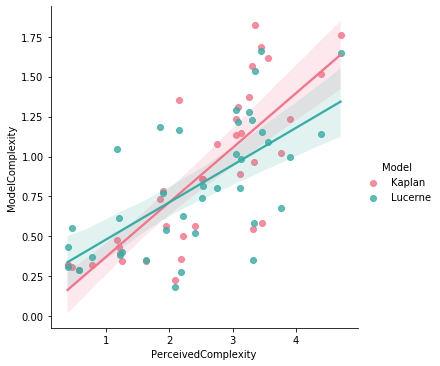

In [29]:
recs = []
recs += [[xx, yy, 'Kaplan'] for xx, yy in zip(X, y)]
recs += [[xx, yy, 'Lucerne'] for xx, yy in zip(X2, y)]
sns_df = pd.DataFrame(recs, columns=['ModelComplexity', 'PerceivedComplexity', 'Model'])
sns.lmplot(x='PerceivedComplexity', y='ModelComplexity', data=sns_df, hue='Model', palette='husl')